In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob

In [2]:
tcga_files = glob.glob('TCGA*')

In [3]:
sorted(tcga_files)[:-1]

['TCGA-BLCA.star_tpm.tsv.gz',
 'TCGA-BRCA.star_tpm.tsv.gz',
 'TCGA-HNSC.star_tpm.tsv.gz',
 'TCGA-KIRC.star_tpm.tsv.gz',
 'TCGA-LUAD.star_tpm.tsv.gz',
 'TCGA-LUSC.star_tpm.tsv.gz',
 'TCGA-UCEC.star_tpm.tsv.gz']

In [4]:
tcga_files_dict = {}
for p in sorted(tcga_files)[:-1]:
    tcga_files_dict[p.split('.')[0].split('-')[1]] = p
    

In [5]:
tcga_files_dict

{'BLCA': 'TCGA-BLCA.star_tpm.tsv.gz',
 'BRCA': 'TCGA-BRCA.star_tpm.tsv.gz',
 'HNSC': 'TCGA-HNSC.star_tpm.tsv.gz',
 'KIRC': 'TCGA-KIRC.star_tpm.tsv.gz',
 'LUAD': 'TCGA-LUAD.star_tpm.tsv.gz',
 'LUSC': 'TCGA-LUSC.star_tpm.tsv.gz',
 'UCEC': 'TCGA-UCEC.star_tpm.tsv.gz'}

In [6]:
genemap_df = pd.read_csv('gencode.v36.annotation.gtf.gene.probemap', sep='\t')

In [7]:
genemap_df.head()

,id,gene,chrom,chromStart,chromEnd,strand
0,ENSG00000223972.5,DDX11L1,chr1,11869,14409,+
1,ENSG00000227232.5,WASH7P,chr1,14404,29570,-
2,ENSG00000278267.1,MIR6859-1,chr1,17369,17436,-
3,ENSG00000243485.5,MIR1302-2HG,chr1,29554,31109,+
4,ENSG00000284332.1,MIR1302-2,chr1,30366,30503,+


In [8]:
gene_id_gene_name = dict(zip(genemap_df.id, genemap_df.gene))

In [9]:
cancer_df_dict = {}
for c in tcga_files_dict:
    cancer_df = pd.read_csv(tcga_files_dict[c], sep='\t')
    cancer_df['Gene_name'] = cancer_df.Ensembl_ID.map(gene_id_gene_name)
    cancer_df = cancer_df.set_index('Gene_name')
    cancer_df = cancer_df[[i for i in cancer_df.columns if 'TCGA' in i]]
    cancer_df_dict[c] = cancer_df

In [10]:
dapars_apa = pd.read_csv('41467_2014_BFncomms6274_MOESM506_ESM.csv')

In [11]:
dapars_apa['Gene_name'] = dapars_apa.apply(lambda x: x['Event_id'].split('|')[1], axis=1)

In [12]:
dapars_apa = dapars_apa.set_index('Gene_name')
dapars_apa = dapars_apa[[i for i in dapars_apa.columns if i != 'Event_id']]
dapars_apa.head()

,LUSC,UCEC,BLCA,LUAD,BRCA,HNSC,KIRC
Gene_name,,,,,,,
LMAN2,-0.251000,NaN,NaN,NaN,NaN,NaN,NaN
WAPAL,-0.297059,-0.396250,NaN,-0.27125,NaN,NaN,NaN
LOX,-0.306364,NaN,NaN,NaN,NaN,NaN,NaN
NDUFA6,NaN,-0.271429,-0.24,NaN,NaN,NaN,NaN
MFSD8,-0.276316,NaN,NaN,NaN,-0.265357,NaN,NaN


In [13]:
cancer_type = []
shortening = []
lengthening = []
for c in dapars_apa.columns:
    cancer_type.append(c)
    lengthening.append(dapars_apa[dapars_apa[c] >0].shape[0])
    shortening.append(-dapars_apa[dapars_apa[c] <0].shape[0])

In [14]:
tcga_apa_events = pd.DataFrame([cancer_type, shortening, lengthening], index=['cancer', 'shortening', 'lengthening']).T


In [15]:
candidates_list = pd.read_csv('candidate_list.txt', header=None)[0].tolist()

In [16]:
salmon_path = '/tscc/nfs/home/pjaganna1/projects/apa_screen_yongsheng/apa_kd_data_graveley_redo/salmon_out'

In [17]:
sequenced_samples = set([i.split('/')[-1].split('-')[0] for i in glob.glob(os.path.join(salmon_path, '*.sf'))])

In [18]:
remove_candidates = ['GTSF1']

In [19]:
final_candidate_list = list((set(candidates_list).intersection(sequenced_samples)) - set(remove_candidates))

In [20]:
final_candidate_list = final_candidate_list + ['NUDT21', 'CPSF6']

In [22]:
exp_dict = {}
for g in final_candidate_list:
    exp_dict[g] = {}
    for c in tcga_apa_events.sort_values(by='shortening', ascending=False)['cancer'].tolist():
        exp_dict[g][c] = cancer_df_dict[c].loc[g]

In [23]:
tcga_apa_events_pct = tcga_apa_events.copy()
# Make shortening values positive
tcga_apa_events_pct["shortening"] = tcga_apa_events_pct["shortening"].abs()

# Calculate percentages
tcga_apa_events_pct["shortening_percentage"] = (tcga_apa_events_pct["shortening"] / (tcga_apa_events_pct["shortening"] + tcga_apa_events_pct["lengthening"])) * 100
tcga_apa_events_pct["lengthening_percentage"] = (tcga_apa_events_pct["lengthening"] / (tcga_apa_events_pct["shortening"] + tcga_apa_events_pct["lengthening"])) * 100
tcga_apa_events_pct = tcga_apa_events_pct.set_index('cancer')[['shortening']]

In [24]:
from scipy import stats

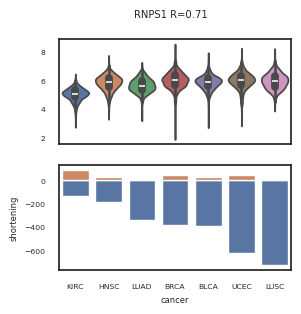

In [26]:
spearmanr_list = []
sns.set(font_scale=0.5)
sns.set_style('white')
exp_averages = {}
for g in ['RNPS1']:
    exp_averages[g] = {}
    for c in cancer_df_dict:
        exp_averages[g][c] = exp_dict[g][c].mean()
    stat, pval = stats.spearmanr(tcga_apa_events_pct['shortening'],
                          tcga_apa_events_pct.index.map(exp_averages[g])
                                )
    spearmanr_list.append([g, stat, -np.log10(pval)])

    fig, axes = plt.subplots(2, 1, sharex=True, figsize=(3,3))
    sns.violinplot(exp_dict[g], ax=axes[0])

    sns.barplot(data=tcga_apa_events.sort_values(by='shortening', ascending=False), x='cancer', y='shortening', ax=axes[1])
    sns.barplot(data=tcga_apa_events.sort_values(by='shortening', ascending=False), x='cancer', y='lengthening', ax=axes[1])
    plt.suptitle(g + ' R={0:.2f}'.format(stat))
    plt.show()